In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import itertools
import seaborn as sns

from scipy import interpolate
from matplotlib import pyplot as plt

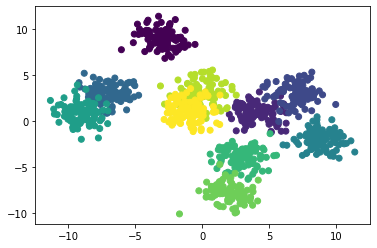

In [2]:
load=True
num_cells = 1000
num_dims_reduced = 2
num_branches = 2
K = 10 # cluster labels
if num_branches == 2:
    filename = 'fakedata-2branch.npy'
    start_node = 5
else:
    filename = 'fakedata-1branch.npy'
    start_node = 4

if load:
    data = np.load(filename, allow_pickle=True).item()
    cluster_labels = data['cluster_labels']
    data = data['data']
else:
    cluster_labels = np.zeros([num_cells], dtype=int)
    data = list()
    for k in range(K):
        cells = num_cells // K
        offset = torch.randint(20, torch.Size([2])) - 10
        print(offset.shape)

        data.append(offset + torch.randn(torch.Size([num_cells//K, num_dims_reduced])))
        cluster_labels[k*cells:(k+1)*cells] = k
    data = torch.cat(data)
    np.save(filename, dict(data=data, cluster_labels=cluster_labels))
plt.scatter(data[:, 0], data[:, 1], c=cluster_labels)

cluster_labels_onehot = np.zeros((cluster_labels.shape[0], cluster_labels.max()+1))
cluster_labels_onehot[np.arange(cluster_labels.shape[0]), cluster_labels] = 1

  0%|          | 0/10 [00:00<?, ?it/s]

Lineages: [Lineage[5, 3, 9, 8, 0], Lineage[5, 3, 9, 8, 1, 2, 4], Lineage[5, 3, 9, 8, 1, 6, 7]]
Reversing from leaf to root
Averaging branch @1 with lineages: [1, 2] [<pcurve.PrincipalCurve object at 0x0000026A86426288>, <pcurve.PrincipalCurve object at 0x0000026A84335DC8>]
Averaging branch @8 with lineages: [0, 1, 2] [<pcurve.PrincipalCurve object at 0x0000026A84335B08>, <pcurve.PrincipalCurve object at 0x0000026A8642C088>]
Shrinking branch @8 with curves: [<pcurve.PrincipalCurve object at 0x0000026A84335B08>, <pcurve.PrincipalCurve object at 0x0000026A8642C088>]
Shrinking branch @1 with curves: [<pcurve.PrincipalCurve object at 0x0000026A86426288>, <pcurve.PrincipalCurve object at 0x0000026A84335DC8>]


 10%|█         | 1/10 [00:03<00:31,  3.49s/it]

Reversing from leaf to root
Averaging branch @1 with lineages: [1, 2] [<pcurve.PrincipalCurve object at 0x0000026A84190D88>, <pcurve.PrincipalCurve object at 0x0000026A841907C8>]
Averaging branch @8 with lineages: [0, 1, 2] [<pcurve.PrincipalCurve object at 0x0000026A84190988>, <pcurve.PrincipalCurve object at 0x0000026A84190308>]
Shrinking branch @8 with curves: [<pcurve.PrincipalCurve object at 0x0000026A84190988>, <pcurve.PrincipalCurve object at 0x0000026A84190308>]
Shrinking branch @1 with curves: [<pcurve.PrincipalCurve object at 0x0000026A84190D88>, <pcurve.PrincipalCurve object at 0x0000026A841907C8>]


 20%|██        | 2/10 [00:07<00:28,  3.59s/it]

Reversing from leaf to root
Averaging branch @1 with lineages: [1, 2] [<pcurve.PrincipalCurve object at 0x0000026A86455588>, <pcurve.PrincipalCurve object at 0x0000026A86455148>]
Averaging branch @8 with lineages: [0, 1, 2] [<pcurve.PrincipalCurve object at 0x0000026A861C2808>, <pcurve.PrincipalCurve object at 0x0000026A864557C8>]
Shrinking branch @8 with curves: [<pcurve.PrincipalCurve object at 0x0000026A861C2808>, <pcurve.PrincipalCurve object at 0x0000026A864557C8>]
Shrinking branch @1 with curves: [<pcurve.PrincipalCurve object at 0x0000026A86455588>, <pcurve.PrincipalCurve object at 0x0000026A86455148>]


 30%|███       | 3/10 [00:10<00:25,  3.62s/it]

Reversing from leaf to root
Averaging branch @1 with lineages: [1, 2] [<pcurve.PrincipalCurve object at 0x0000026A8427AB48>, <pcurve.PrincipalCurve object at 0x0000026A8427A1C8>]
Averaging branch @8 with lineages: [0, 1, 2] [<pcurve.PrincipalCurve object at 0x0000026A8427ACC8>, <pcurve.PrincipalCurve object at 0x0000026A8427A348>]
Shrinking branch @8 with curves: [<pcurve.PrincipalCurve object at 0x0000026A8427ACC8>, <pcurve.PrincipalCurve object at 0x0000026A8427A348>]
Shrinking branch @1 with curves: [<pcurve.PrincipalCurve object at 0x0000026A8427AB48>, <pcurve.PrincipalCurve object at 0x0000026A8427A1C8>]


 40%|████      | 4/10 [00:14<00:21,  3.62s/it]

Reversing from leaf to root
Averaging branch @1 with lineages: [1, 2] [<pcurve.PrincipalCurve object at 0x0000026A84376688>, <pcurve.PrincipalCurve object at 0x0000026A843769C8>]
Averaging branch @8 with lineages: [0, 1, 2] [<pcurve.PrincipalCurve object at 0x0000026A84376C08>, <pcurve.PrincipalCurve object at 0x0000026A84376C48>]
Shrinking branch @8 with curves: [<pcurve.PrincipalCurve object at 0x0000026A84376C08>, <pcurve.PrincipalCurve object at 0x0000026A84376C48>]
Shrinking branch @1 with curves: [<pcurve.PrincipalCurve object at 0x0000026A84376688>, <pcurve.PrincipalCurve object at 0x0000026A843769C8>]


 50%|█████     | 5/10 [00:18<00:18,  3.62s/it]

Reversing from leaf to root
Averaging branch @1 with lineages: [1, 2] [<pcurve.PrincipalCurve object at 0x0000026A86217B88>, <pcurve.PrincipalCurve object at 0x0000026A86217A08>]
Averaging branch @8 with lineages: [0, 1, 2] [<pcurve.PrincipalCurve object at 0x0000026A86217D08>, <pcurve.PrincipalCurve object at 0x0000026A863B4E48>]
Shrinking branch @8 with curves: [<pcurve.PrincipalCurve object at 0x0000026A86217D08>, <pcurve.PrincipalCurve object at 0x0000026A863B4E48>]
Shrinking branch @1 with curves: [<pcurve.PrincipalCurve object at 0x0000026A86217B88>, <pcurve.PrincipalCurve object at 0x0000026A86217A08>]


 60%|██████    | 6/10 [00:21<00:14,  3.63s/it]

Reversing from leaf to root
Averaging branch @1 with lineages: [1, 2] [<pcurve.PrincipalCurve object at 0x0000026A82C4E6C8>, <pcurve.PrincipalCurve object at 0x0000026A82C4E248>]
Averaging branch @8 with lineages: [0, 1, 2] [<pcurve.PrincipalCurve object at 0x0000026A82C4ED48>, <pcurve.PrincipalCurve object at 0x0000026A84376C48>]
Shrinking branch @8 with curves: [<pcurve.PrincipalCurve object at 0x0000026A82C4ED48>, <pcurve.PrincipalCurve object at 0x0000026A84376C48>]
Shrinking branch @1 with curves: [<pcurve.PrincipalCurve object at 0x0000026A82C4E6C8>, <pcurve.PrincipalCurve object at 0x0000026A82C4E248>]


 70%|███████   | 7/10 [00:25<00:10,  3.63s/it]

Reversing from leaf to root
Averaging branch @1 with lineages: [1, 2] [<pcurve.PrincipalCurve object at 0x0000026A84436B88>, <pcurve.PrincipalCurve object at 0x0000026A861D6F48>]
Averaging branch @8 with lineages: [0, 1, 2] [<pcurve.PrincipalCurve object at 0x0000026A861D6948>, <pcurve.PrincipalCurve object at 0x0000026A861D6348>]
Shrinking branch @8 with curves: [<pcurve.PrincipalCurve object at 0x0000026A861D6948>, <pcurve.PrincipalCurve object at 0x0000026A861D6348>]
Shrinking branch @1 with curves: [<pcurve.PrincipalCurve object at 0x0000026A84436B88>, <pcurve.PrincipalCurve object at 0x0000026A861D6F48>]


 80%|████████  | 8/10 [00:29<00:07,  3.66s/it]

Reversing from leaf to root
Averaging branch @1 with lineages: [1, 2] [<pcurve.PrincipalCurve object at 0x0000026A843DA288>, <pcurve.PrincipalCurve object at 0x0000026A843DA388>]
Averaging branch @8 with lineages: [0, 1, 2] [<pcurve.PrincipalCurve object at 0x0000026A843DAEC8>, <pcurve.PrincipalCurve object at 0x0000026A861925C8>]
Shrinking branch @8 with curves: [<pcurve.PrincipalCurve object at 0x0000026A843DAEC8>, <pcurve.PrincipalCurve object at 0x0000026A861925C8>]
Shrinking branch @1 with curves: [<pcurve.PrincipalCurve object at 0x0000026A843DA288>, <pcurve.PrincipalCurve object at 0x0000026A843DA388>]


 90%|█████████ | 9/10 [00:32<00:03,  3.67s/it]

Reversing from leaf to root
Averaging branch @1 with lineages: [1, 2] [<pcurve.PrincipalCurve object at 0x0000026A86459348>, <pcurve.PrincipalCurve object at 0x0000026A84237048>]
Averaging branch @8 with lineages: [0, 1, 2] [<pcurve.PrincipalCurve object at 0x0000026A86459A88>, <pcurve.PrincipalCurve object at 0x0000026A86459048>]
Shrinking branch @8 with curves: [<pcurve.PrincipalCurve object at 0x0000026A86459A88>, <pcurve.PrincipalCurve object at 0x0000026A86459048>]
Shrinking branch @1 with curves: [<pcurve.PrincipalCurve object at 0x0000026A86459348>, <pcurve.PrincipalCurve object at 0x0000026A84237048>]


100%|██████████| 10/10 [00:36<00:00,  3.64s/it]


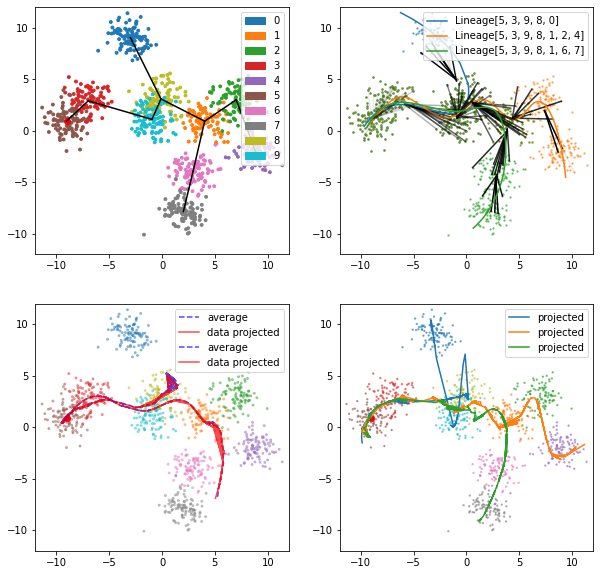

In [11]:
from slingshot import Slingshot

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
custom_xlim = (-12, 12)
custom_ylim = (-12, 12)
plt.setp(axes, xlim=custom_xlim, ylim=custom_ylim)

slingshot = Slingshot(data, cluster_labels_onehot, start_node=start_node, debug_axes=axes)
lineages = slingshot.get_lineages()
slingshot.get_curves(num_epochs=10)

In [ ]:
tttt

In [ ]:
def scipy_interpolate():
    x = np.arange(0, 2*np.pi+np.pi/4, 2*np.pi/8)
    y = np.sin(x)

    tck = interpolate.splrep(x, y, s=0.5)
    xnew = np.arange(0, 2*np.pi, np.pi/50)

    ynew = interpolate.splev(xnew, tck, der=0)

    plt.plot(xnew, ynew)
    plt.plot(xnew, np.sin(xnew))


